# Exploratory Data Analysis
## Introduction

This notebook is for exploring the data set after initial cleaning.

The schema for each file is as follows (copied verbatim from provided materials):

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


Note: Users that didn't provide their age have their age encoded as 118.
Note: BOGO stands for "buy one get one"

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.patches as mpatches

# Sometimes use display instead of print
from IPython.display import display

# queue data structure
from collections import deque

# debugging
from IPython.core.debugger import set_trace

%matplotlib inline

In [2]:
# Read the cleaned data
portfolio = pd.read_csv('./data/portfolio_clean.csv')
profile = pd.read_csv('./data/profile_clean.csv')
transcript = pd.read_csv('./data/transcript_clean.csv')

In [3]:
display(portfolio.head())
display(profile.head())
display(transcript.head())

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
0,1,0,1,1,1,bogo,168,10,10
1,2,1,1,1,1,bogo,120,10,10
2,3,1,1,1,0,informational,96,0,0
3,4,1,1,1,0,bogo,168,5,5
4,5,1,1,0,0,discount,240,20,5


,customer_id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


,customer_id,time,event,amount,reward,offer_id
0,4,0,offer_received,NaN,NaN,4.0
1,5,0,offer_received,NaN,NaN,5.0
2,6,0,offer_received,NaN,NaN,10.0
3,7,0,offer_received,NaN,NaN,7.0
4,8,0,offer_received,NaN,NaN,2.0


## Exploring the offer portfolio
Portfolio describes the offers shown to customers.

There are only 10 offers so we can look at them all. The difficulty is the amount a customer has to spend to get the reward amount. Informational offers have no difficulty or reward.

In [4]:
portfolio.sort_values(['offer_type', 'duration'])

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
1,2,1,1,1,1,bogo,120,10,10
8,9,1,1,1,1,bogo,120,5,5
0,1,0,1,1,1,bogo,168,10,10
3,4,1,1,1,0,bogo,168,5,5
5,6,1,1,1,1,discount,168,7,3
9,10,1,1,1,0,discount,168,10,2
4,5,1,1,0,0,discount,240,20,5
6,7,1,1,1,1,discount,240,10,2
7,8,0,1,1,1,informational,72,0,0
2,3,1,1,1,0,informational,96,0,0


## Exploring the customer profiles


There are 17000 customers in the dataset. For most customers, (87%) we have gender, age, and income information as well. There are no customers where we partially have gender/age/information (i.e. all the NAs are in the same place).

In [5]:
profile.head()

,customer_id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


In [6]:
profile.shape

(17000, 5)

In [7]:
profile.gender.notnull().mean()

0.8720588235294118

In [8]:
# If all the NAs are in the same rows,
# exclusive OR will be 0.
# Only do 2/3 tests because of commutation.
print((profile.gender.isna() ^ profile.age.isna()).sum())
print((profile.gender.isna() ^ profile.income.isna()).sum())

0
0


<br/><br/>

Let's take a look at the distribution of the gender/age/income columns

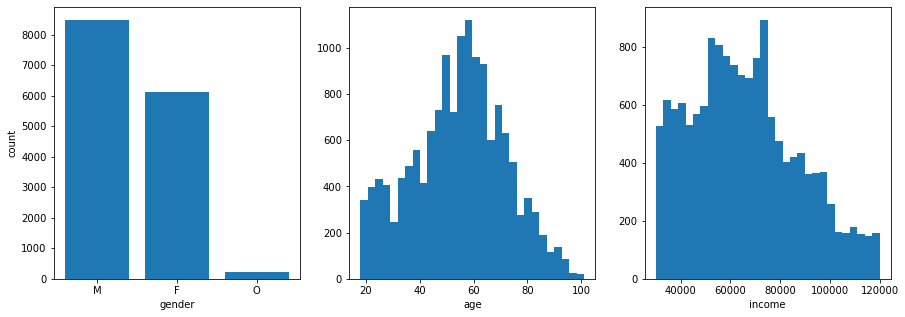

In [9]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15,5)
gender_plot = ax[0]
age_plot = ax[1]
income_plot = ax[2]

gender_plot.bar(profile.gender.value_counts().index, profile.gender.value_counts())
age_plot.hist(profile.age, 30)
income_plot.hist(profile.income, 30);

gender_plot.set_xlabel('gender')
gender_plot.set_ylabel('count')

age_plot.set_xlabel('age')
income_plot.set_xlabel('income');

<br/><br/>

The `became_member_on` column is currently not a datetime object, so let's change it.

In [10]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])

In [11]:
# Summary of the column
profile.became_member_on.describe(datetime_is_numeric=True)

count                            17000
mean     2017-02-23 13:12:10.164706048
min                2013-07-29 00:00:00
25%                2016-05-26 00:00:00
50%                2017-08-02 00:00:00
75%                2017-12-30 00:00:00
max                2018-07-26 00:00:00
Name: became_member_on, dtype: object

<br><br>

There's are some chunks of when signs ups are.

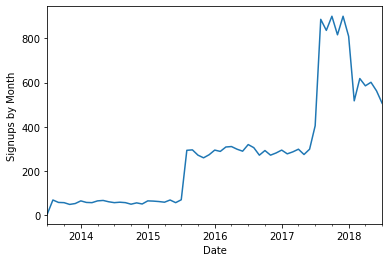

In [12]:
# User signups by month
profile.became_member_on.value_counts().resample("M").sum().plot();
plt.xlabel('Date')
plt.ylabel('Signups by Month');

## Exploring the transcript data

### Data overview

The `transcript` dataframe contains 306534 events over a period of one month (714 hours). During this time, a number of events can happen to customers (there are 17000 customers, which matches the number in the customer profiles). Customers may receive an offer ("offer_received"), view an offer ("offer_viewed"), complete an offer ("offer_completed"), and/or make a transaction ("transaction"). `amount` and `reward` are filled in for "offer_completed" events; `amount` is also filled in for "transaction" events.

In [13]:
print(f"Transcript shape is {transcript.shape}")
print(f"Start time is {transcript.time.min()}, end time is {transcript.time.max()} hours")
print(f"The number of unique customers in the transcript is {transcript.customer_id.nunique()}.")

Transcript shape is (306534, 6)
Start time is 0, end time is 714 hours
The number of unique customers in the transcript is 17000.


In [14]:
transcript.head(3)

,customer_id,time,event,amount,reward,offer_id
0,4,0,offer_received,NaN,NaN,4.0
1,5,0,offer_received,NaN,NaN,5.0
2,6,0,offer_received,NaN,NaN,10.0


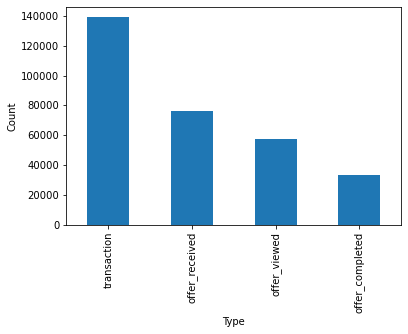

In [15]:
# Breakdown of event types.
ax = transcript.event.value_counts().plot(kind='bar')
ax.set_xlabel('Type')
ax.set_ylabel('Count');

<br/><br/>

### What is the distribution of transaction amounts?

The median transaction amount is 8.89 and the mean is 12.78. This distribution is right skewed: the 99th percentile is at 25.79, but 1% of transactions span all the way up to 1062.28. 

Although this dataset doesn't have the actual transaction items, I would speculate that the smaller distribution are mostly coffee orders, and the larger distribution is coffee + food. There are also a number of transactions less than a dollar, down to 0.05, and I am unsure what those would represent.

In [16]:
transactions = transcript[transcript.event == 'transaction']

In [17]:
transactions.head(3)

,customer_id,time,event,amount,reward,offer_id
12654,42,0,transaction,0.83,NaN,NaN
12657,56,0,transaction,34.56,NaN,NaN
12659,64,0,transaction,13.23,NaN,NaN


In [18]:
transactions.amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [19]:
print(f"Quantiles: 90%, {round(transactions.amount.quantile(q=0.90), 2)}.\n"
      f"           95%, {round(transactions.amount.quantile(q=0.95), 2)}.\n"
      f"           99%, {round(transactions.amount.quantile(q=0.99), 2)}.")

Quantiles: 90%, 25.49.
           95%, 29.91.
           99%, 40.02.


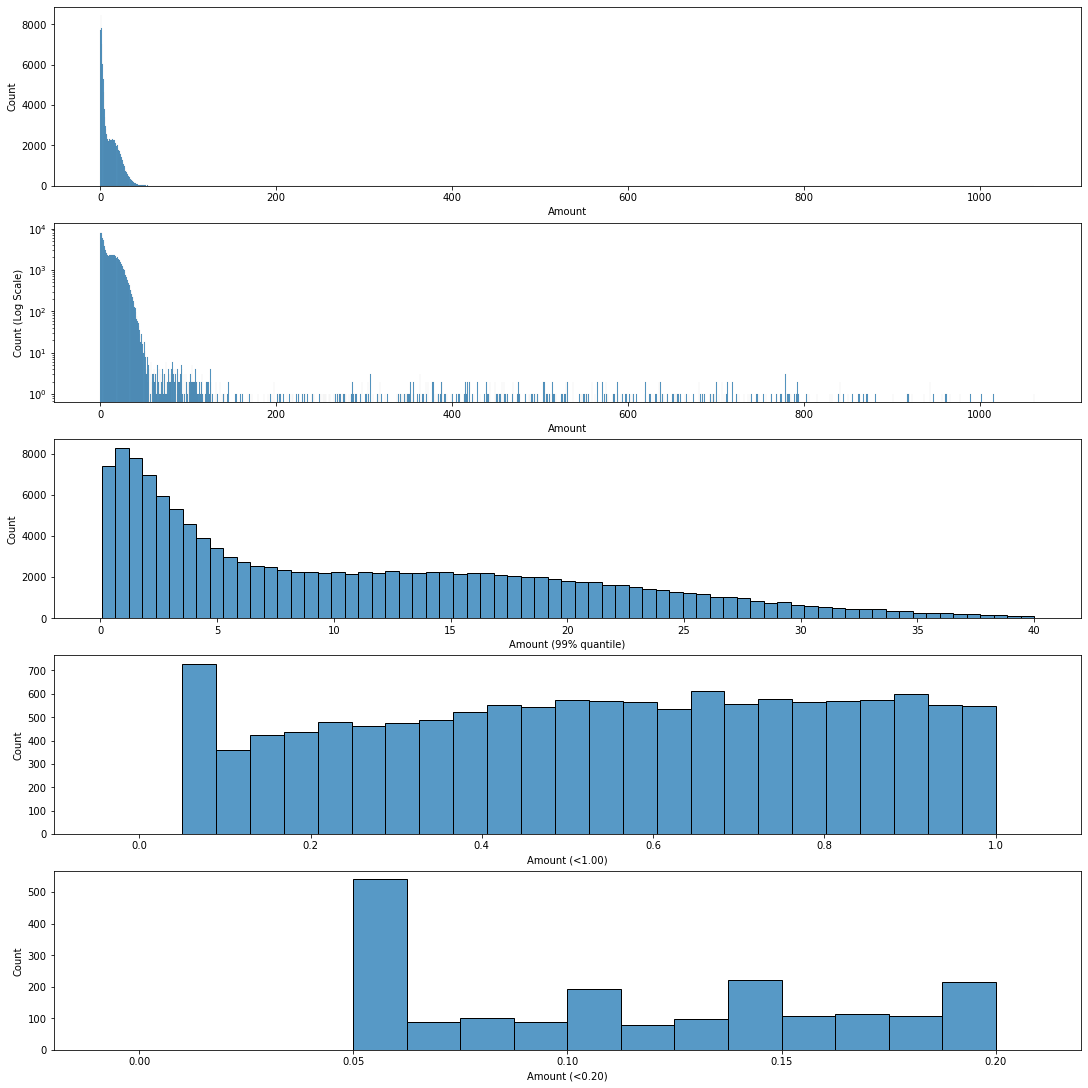

In [20]:
# Transaction amounts
fig, ax = plt.subplots(5, 1, figsize=(15,15), constrained_layout=True)
sns.histplot(data=transactions, x='amount', ax=ax[0])
sns.histplot(data=transactions, x='amount', ax=ax[1])
sns.histplot(data=transactions[transactions.amount <= 40.02], x='amount', ax=ax[2])
sns.histplot(data=transactions[transactions.amount <= 1.00], x='amount', ax=ax[3])
sns.histplot(data=transactions[transactions.amount <= 0.2], x='amount', ax=ax[4])
ax[0].set_xlabel('Amount')
ax[1].set_yscale('log')
ax[1].set_ylabel('Count (Log Scale)')
ax[1].set_xlabel('Amount')
ax[2].set_xlim(0-2,40.02+2)
ax[2].set_xlabel('Amount (99% quantile)')
ax[3].set_xlim(0-0.1, 1+0.1)
ax[3].set_xlabel('Amount (<1.00)')
ax[4].set_xlim(0-0.02, 0.2+0.02)
ax[4].set_xlabel('Amount (<0.20)');

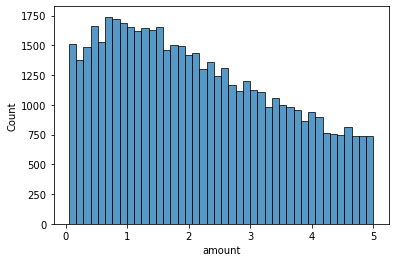

In [21]:
# A look at 0 to 5 dollars
ax = sns.histplot(data=transactions[transactions.amount <= 5], x='amount')

In [22]:
print(f"Number of transactions at 0.05: {(transactions.amount == 0.05).sum()}")

Number of transactions at 0.05: 431


### What is the distribution of transactions per person.
There's several questions we can ask here.

First, this is the distribution of total spend per customer.

count    16578.000000
mean       107.096874
std        126.393939
min          0.050000
25%         23.682500
50%         72.410000
75%        150.937500
max       1608.690000
Name: amount, dtype: float64

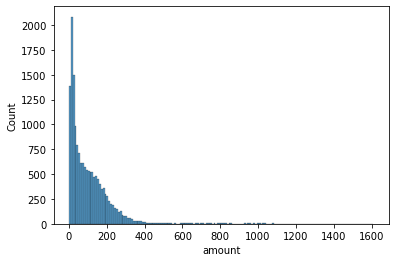

In [23]:
# Distribution of total spend per person.
tpc = transactions.groupby('customer_id')['amount'] # Transactions Per Customer
display(tpc.sum().describe())
sns.histplot(data=tpc.sum());

<br><br>

This is the distribution of the number of transactions per customer.

count    16578.000000
mean         8.381771
std          5.009822
min          1.000000
25%          5.000000
50%          7.000000
75%         11.000000
max         36.000000
Name: amount, dtype: float64

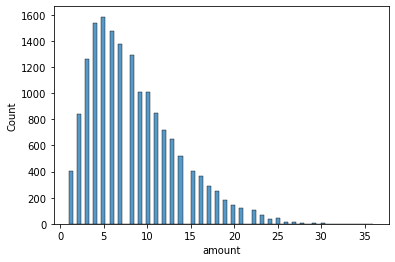

In [24]:
# Distribution of number of transactions per person.
display(tpc.count().describe())
sns.histplot(data=tpc.count());

In [25]:
# Sanity check that the customer ordering for the count and the sum are the same.
(tpc.count().index == tpc.sum().index).all()

True

<br><br>

This is the distribution of the total spend vs the number of transactions per customer.

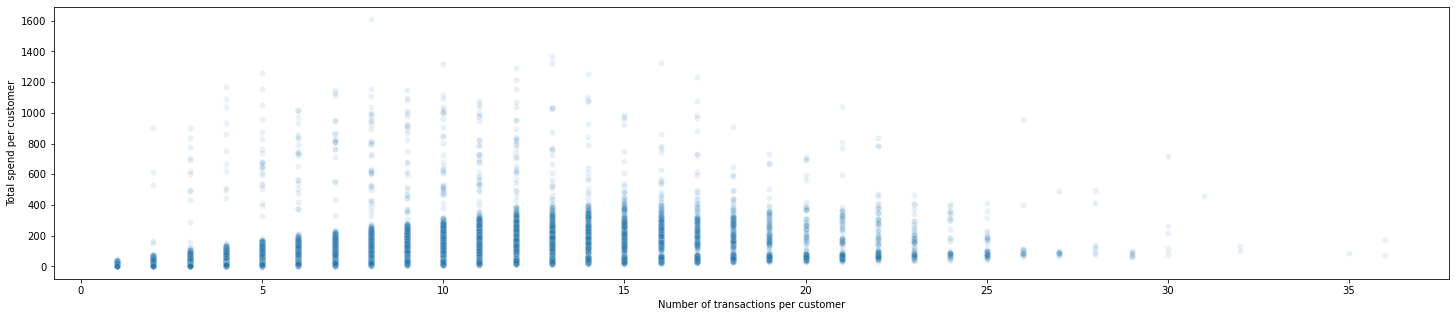

In [26]:
fig, ax = plt.subplots(figsize=(25,5))
sns.scatterplot(x=tpc.count(), y=tpc.sum(), alpha=0.1, ax=ax)
ax.set_xlabel('Number of transactions per customer')
ax.set_ylabel('Total spend per customer');

### What is the relationship between transactions and customer variables?

Let's take a look at the sum of transactions vs a customers age, income, and gender. The female category has a larger mean spend than the male category, with the other gender category in between. People without demographic information have a much lower spend.

Note: The O (other) gender is much smaller than M and F in number.

In [27]:
# tpc: transactions per customer
tpc_cust_vars = tpc.sum().to_frame().merge(profile, left_index=True, right_on='customer_id', how='left')
tpc_cust_vars.head(2)

,amount,customer_id,gender,age,income,became_member_on
0,20.40,1,NaN,NaN,NaN,2017-02-12
1,77.01,2,F,55.0,112000.0,2017-07-15


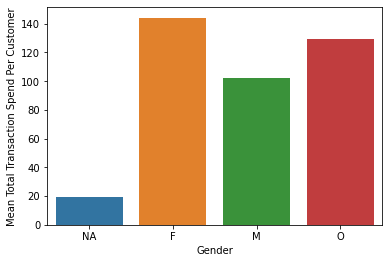

In [28]:
sns.barplot(data=tpc_cust_vars.fillna({'gender':'NA'}), x='gender', y='amount', ci=None);
plt.ylabel("Mean Total Transaction Spend Per Customer")
plt.xlabel("Gender");

<br><br>

Spending is fairly evenly spread across age. Customers without demographic information (coded as age = -1 here) have fewer higher spending customers.

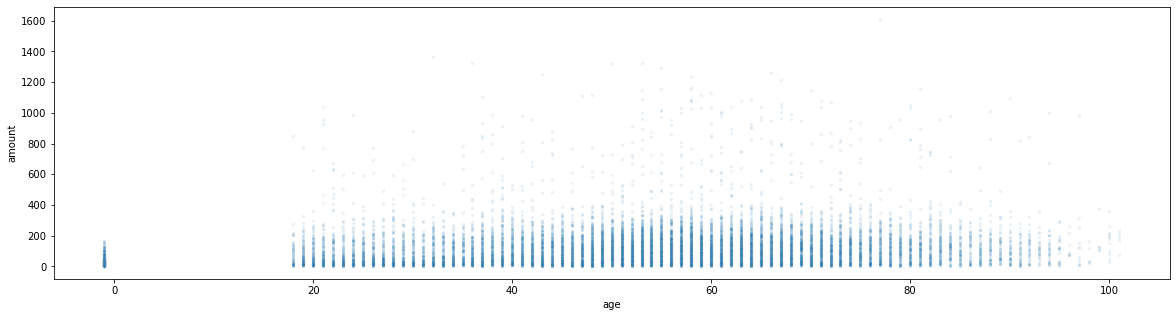

In [29]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.scatterplot(ax=ax, data=tpc_cust_vars.fillna({'age':-1}), x='age', y='amount', s=10, alpha=0.1);

<br><br>

For income vs. amount spent, it looks like there are two distributions. Both of these distributions look like they have a positive trend. Customers without demographic information are coded as (-1).

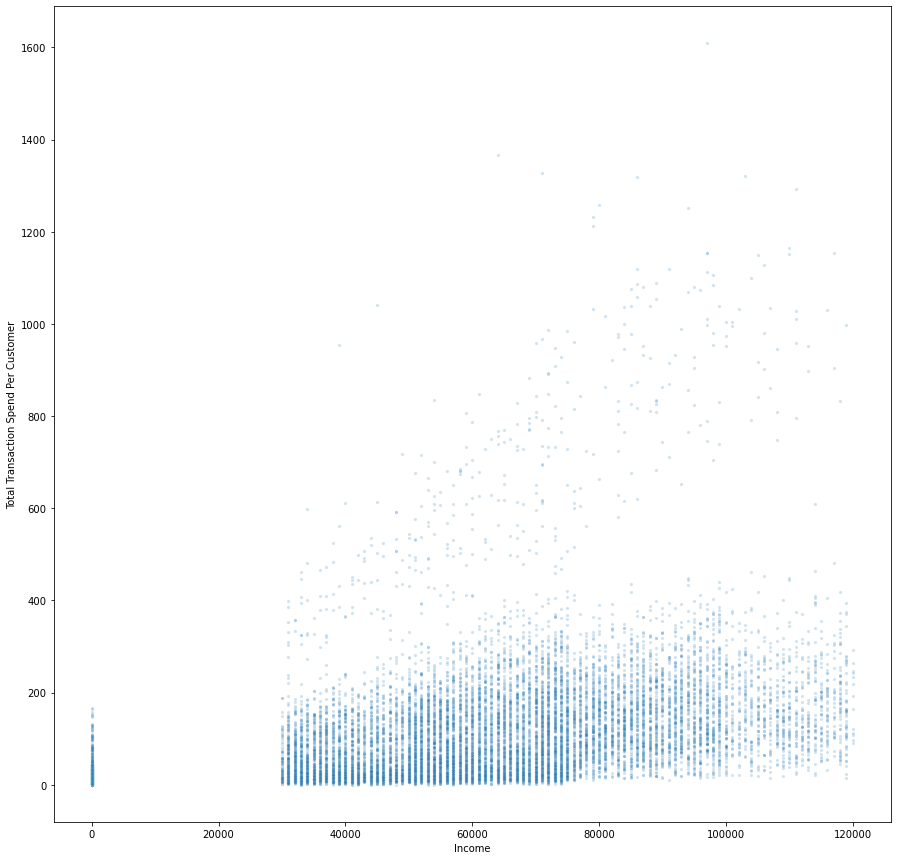

In [30]:
fig, ax = plt.subplots(figsize=(15,15))
sns.scatterplot(ax=ax, data=tpc_cust_vars.fillna({'income': -1}), x='income', y='amount', s=10, alpha=0.2);
plt.ylabel("Total Transaction Spend Per Customer")
plt.xlabel("Income");

<br><br>

This shows the distribution of total spend versus the sign up date of a customer. As before, you can see some of the chunking of the user sign up dates. Because the number of sign up dates is not evenly distributed, it can look like more recent signups have higher spend, but there probably isn't much dependence here for total spend on sign up dates.

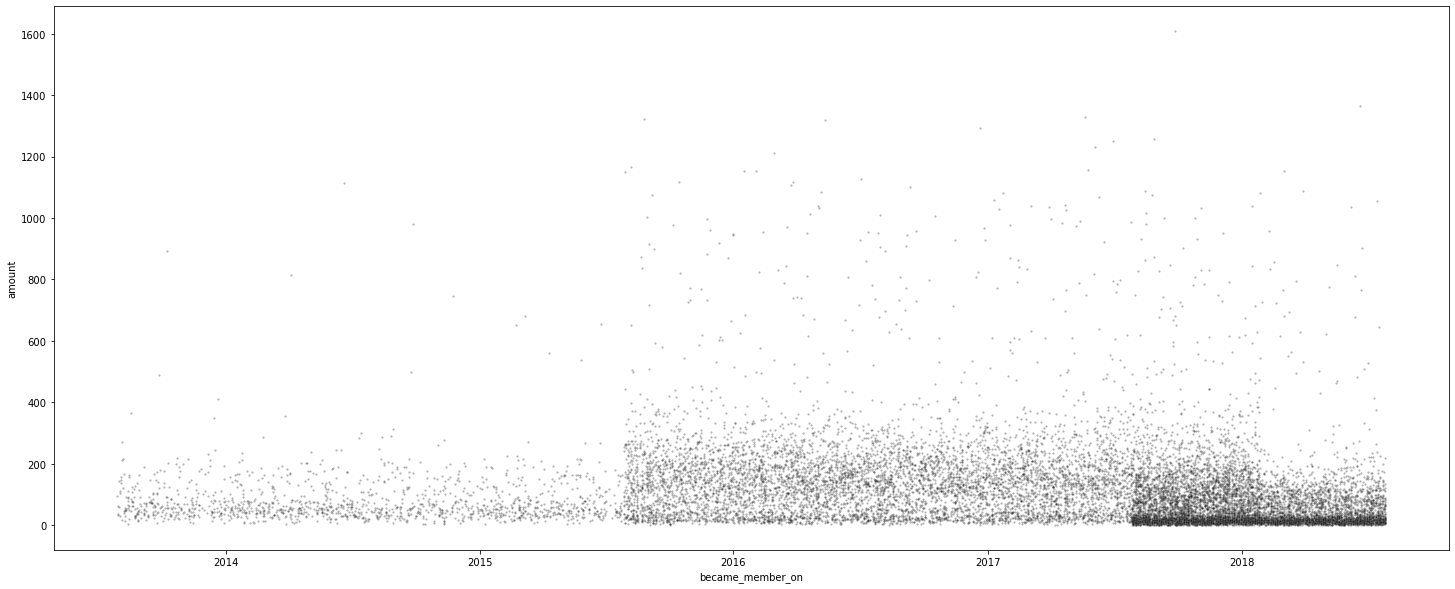

In [31]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.scatterplot(ax=ax, data=tpc_cust_vars, x='became_member_on', y='amount', s=5, alpha=0.3, c=['black']);

In [32]:
profile.head()

,customer_id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


### When are which offers given?

All ten offers are given at all six time points.

In [33]:
received_events = transcript[transcript.event == 'offer_received']
offer_times = received_events.groupby('offer_id')['time'].unique()
offer_times = pd.DataFrame(offer_times.values.tolist(), index=offer_times.index)
offer_times = offer_times.merge(portfolio[['offer_id', 'offer_type']], left_index=True, right_on='offer_id')
display(offer_times)

,0,1,2,3,4,5,offer_id,offer_type
0,0,168,336,408,504,576,1,bogo
1,0,168,336,408,504,576,2,bogo
2,0,168,336,408,504,576,3,informational
3,0,168,336,408,504,576,4,bogo
4,0,168,336,408,504,576,5,discount
5,0,168,336,408,504,576,6,discount
6,0,168,336,408,504,576,7,discount
7,0,168,336,408,504,576,8,informational
8,0,168,336,408,504,576,9,bogo
9,0,168,336,408,504,576,10,discount


### How many customers are given each offer at each time point?

No customers getting more than one offer at a certain time point:

In [34]:
# Are there any customers with more than one more at the same time point?
# Max will be > 1 if there is more than one offer at one time point
# (shouldn't have to be unique offers to be > 1).
# Max is 1, so only 1 offer is given at each time point.
received_events.groupby(['customer_id', 'time']).count()['event'].max()

1

Given that no customers have multiple offers at one time point, the number of customers not getting an offer at any time point is simply the total number of customers minus the number of customers with offers.

The table below shows this.

In [35]:
offer_counts = received_events.groupby(['offer_id', 'time'])[['customer_id']].count()
offer_counts = offer_counts.unstack()['customer_id']
offer_counts.loc['no_offer', :] = transcript.customer_id.nunique() - offer_counts.sum()
offer_counts = offer_counts.astype('int')
display(offer_counts)

time,0,168,336,408,504,576
offer_id,,,,,,
1.0,1292,1319,1245,1278,1248,1276
2.0,1218,1240,1280,1308,1310,1237
3.0,1273,1266,1279,1275,1229,1295
4.0,1245,1296,1275,1274,1261,1326
5.0,1297,1245,1322,1269,1258,1277
6.0,1221,1250,1301,1274,1286,1314
7.0,1318,1250,1243,1222,1283,1281
8.0,1266,1270,1256,1293,1238,1295
9.0,1263,1263,1247,1250,1305,1243


### Are customers given unique offers each time?

Customers may get the same offer more than once. Here is an example customer where offer 7 was offered to them twice.

In [36]:
# Example customer with repeated offer 7
received_events[received_events.customer_id == 1]

,customer_id,time,event,amount,reward,offer_id
53174,1,168,offer_received,NaN,NaN,10.0
110828,1,336,offer_received,NaN,NaN,5.0
150596,1,408,offer_received,NaN,NaN,7.0
201570,1,504,offer_received,NaN,NaN,6.0
245122,1,576,offer_received,NaN,NaN,7.0


<br><br>
This is a count of the number of unique and the total number of offers each customer receives.

,Number of Offers,Type,Count
0,1,unique_offers,172
1,2,unique_offers,1599
2,3,unique_offers,5038
3,4,unique_offers,6563
4,5,unique_offers,3180
5,6,unique_offers,442
6,1,total_offers,73
7,2,total_offers,610
8,3,total_offers,2325
9,4,total_offers,4988


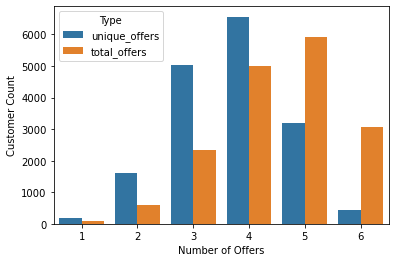

In [37]:
# Number of unique offers per customer in the transcript
unique_offers_per_cust_s = received_events.groupby(['customer_id'])['offer_id'].nunique().value_counts().sort_index()
# Total number of offers per customer
offers_per_cust_s = received_events.groupby(['customer_id'])['offer_id'].count().value_counts().sort_index()
# Disposable dataframe combining the two series above, with some housekeeping on col/index names
_frame = pd.concat([unique_offers_per_cust_s, offers_per_cust_s], axis=1)\
                  .set_axis(['unique_offers', 'total_offers'], axis=1)\
                  .reset_index()\
                  .melt(id_vars='index')
_frame = _frame.rename(columns={'value': 'Count', 'variable':'Type', 'index':'Number of Offers'})
sns.barplot(data=_frame, x='Number of Offers', y='Count', hue='Type')
plt.ylabel('Customer Count')
display(_frame)

In [38]:
_frame.head()

,Number of Offers,Type,Count
0,1,unique_offers,172
1,2,unique_offers,1599
2,3,unique_offers,5038
3,4,unique_offers,6563
4,5,unique_offers,3180


In [39]:
_frame.shape

(12, 3)

In [40]:
_frame

,Number of Offers,Type,Count
0,1,unique_offers,172
1,2,unique_offers,1599
2,3,unique_offers,5038
3,4,unique_offers,6563
4,5,unique_offers,3180
5,6,unique_offers,442
6,1,total_offers,73
7,2,total_offers,610
8,3,total_offers,2325
9,4,total_offers,4988


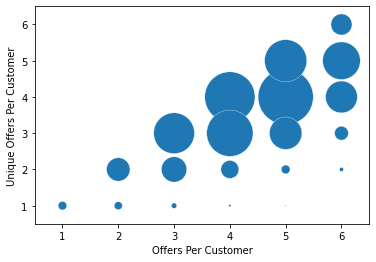

In [41]:
_frame = pd.concat([received_events.groupby(['customer_id'])['offer_id'].count(),
                    received_events.groupby(['customer_id'])['offer_id'].nunique()], axis=1)\
                   .set_axis(['n_offers', 'n_unique_offers'], axis=1)\
                   .value_counts()\
                   .rename('count')\
                   .reset_index()\

# This coefficient controls the area of the largest to smallest point,
# thereby scaling accurately.
size_coeff = _frame['count'].max() / _frame['count'].min()
min_size = 1

g = sns.scatterplot(data=_frame, x="n_offers", y="n_unique_offers", size='count', sizes=(min_size, min_size*size_coeff))
plt.xlabel("Offers Per Customer")
plt.ylabel("Unique Offers Per Customer")
plt.ylim((0.5,6.5))
plt.xlim((0.5,6.5))
g.legend_.remove()

<br><br><br>
### Are offers being given randomly?

Here, I plot the customer ids on the x axis, and time on the y axis (for the time point that offers are offered). The distribution seems random across customer ids.

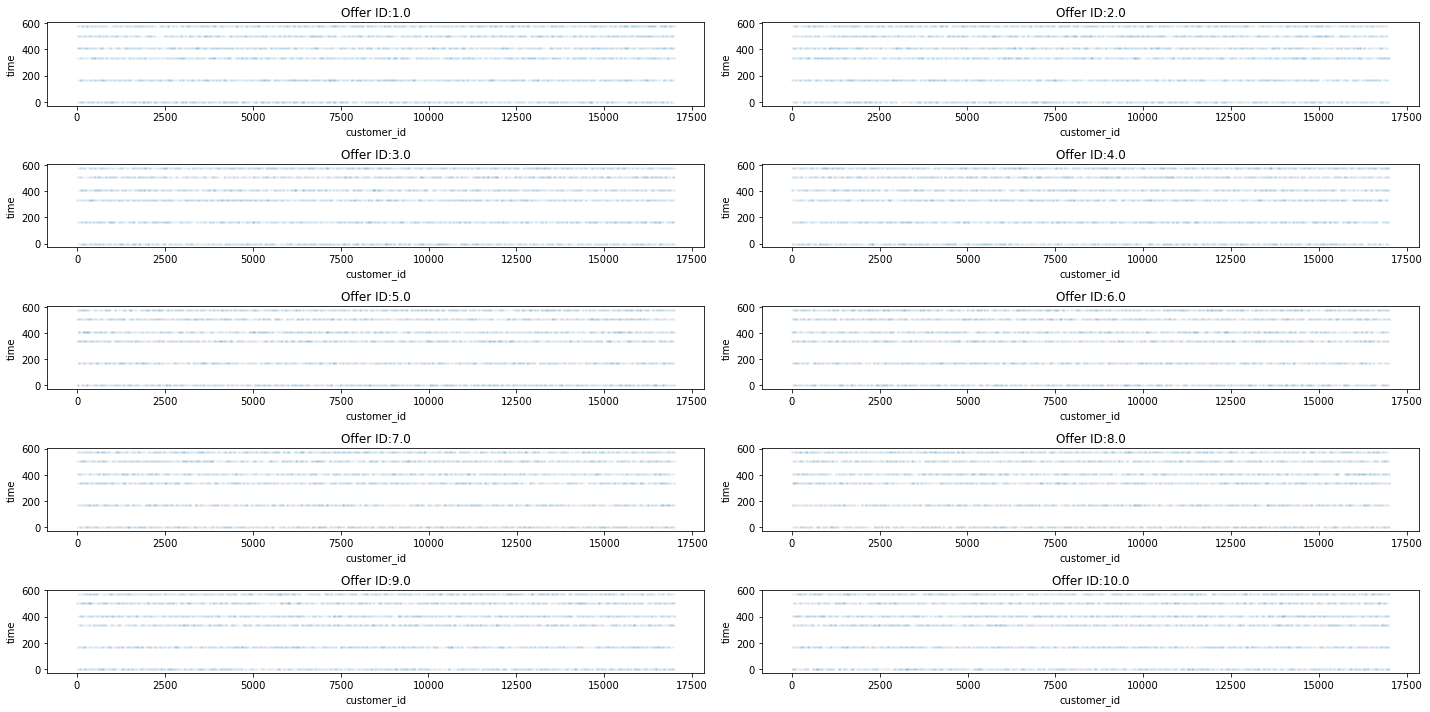

In [42]:
fig, ax = plt.subplots(5, 2, figsize=(20,10))
ax = ax.flatten()
for i, group in enumerate(received_events.groupby(['offer_id'])):
    sns.scatterplot(ax=ax[i], data=group[1], x='customer_id', y='time', alpha=0.05, s=5)
    ax[i].title.set_text(f"Offer ID:{group[0]}")

plt.tight_layout()

<br><br>
### Which customers have viewed/completed which offers?

The start times and durations of offers means that offers are overlapping (i.e. customers may have more than one offer active at once). As well, customers can receive the same offer more than once at different times. Potentially, a customer may be responding to an offer based on repeated exposure to an offer, or be influenced by exposure to other offers.

To simplify this situation, we can measure if a customer responds at any time in the time frame of this data. We'll look at if a customer having received an offer at least once during the time frame of this data, either has viewed or completed the offer at least once.


In the code below, I define a function to collect whether a customer has viewed or completed an offer, on a per offer basis. This results in lists of dataframe that we can iterate through to visualize these data by offer.


In [43]:
def get_offer_action_data(transcript_df, profile_df, offer_id, action_type, contain_demo=True):
    """
    For a given offer id, generates a df combining customer profiles with 
    whether they viewed/completed the offer (if they received the offer) over
    the course of the experiment.
    
    Also converts became_member_on to datetimes.
    
    Note that unlike the version of this function used in model development,
    it does not dummy the gender variable.
    
    Input:
    transcript_df - Transaction/event transcript dataframe.
    profile_df    - Customer profiles.
    offer_id      - Offer id to process.
    action_type   - 'offer_completed' or 'offer_viewed'.
    contain_demo  - If True, returns only customers having age/gender/income demographic data.
                    If False, returns only customers without demographic data.
    
    Returns:
    offer_profile - Dataframe containing customer profiles and offer view/completion status.
    """
    tr = transcript_df
    pro = profile_df
    
    # Get set of offering completing and non-completing customer ids
    offer_customers = set(tr[(tr.offer_id == offer_id) & (tr.event == 'offer_received')].customer_id)
    offer_completed = set(tr[(tr.offer_id == offer_id) & (tr.event == action_type)].customer_id)
    offer_incomplete = offer_customers - offer_completed
    
    # Appending 0/1 for incomplete/complete to customer profile data
    profile_complete = pro[pro.customer_id.isin(offer_completed)].assign(offer_complete = 1)
    profile_incomplete = pro[pro.customer_id.isin(offer_incomplete)].assign(offer_complete = 0)
    
    offer_profile = pd.concat([profile_complete, profile_incomplete]).sort_values('customer_id')
    
    # Customers w/ demographic data
    if contain_demo == True:
        offer_profile = offer_profile.dropna()
    # Customers missing demographic data
    else:
        offer_profile = offer_profile[offer_profile.isna().any(axis=1)]
        
    # Clean the data
    ## Convert became_member_on to datetimes.
    offer_profile['became_member_on'] = pd.to_datetime(offer_profile.became_member_on)
    
    ## Rename column to be the appropriate action type
    offer_profile = offer_profile.rename(columns={'offer_complete': action_type})
    
    return offer_profile

In [44]:
# Customers with demographic data

viewed_customers = []
for offer in portfolio.offer_id:
    viewed_customers.append(get_offer_action_data(transcript, profile, offer, 'offer_viewed', contain_demo=True))
    
completed_customers = []
for offer in portfolio.offer_id:
    completed_customers.append(get_offer_action_data(transcript, profile, offer, 'offer_completed', contain_demo=True))

<br><br>

With the data collected, we can split the data by demographic variables to see how offer view/completion rates are like.  

The following two plots show these rates for female/male/other gender categories. Note that completion rates are 0 for offers 3 and 8 as they are informational offers and thus have no way to be completed.

These rates differ quite a bit on a per offer basis. Note that for several offers view rates are high across categories, whereas completion rates are lower. In high view rate offers, the differences between categories tends to get washed out.

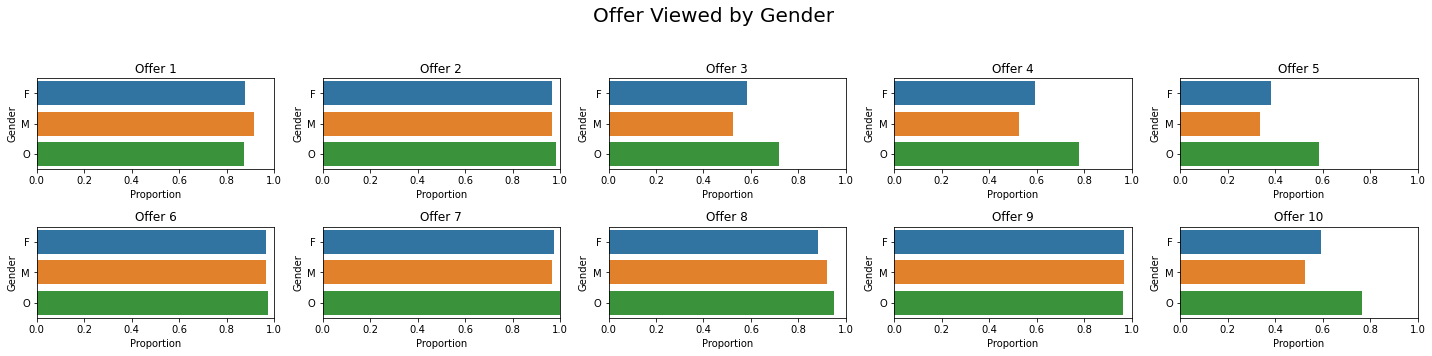

In [77]:
# See https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group 
# Answer by usermay14

# Offer viewed by gender.
fig, ax = plt.subplots(2,5, figsize=(20,5))
ax = ax.flatten()

for i, offer in enumerate(viewed_customers):
    (offer.groupby('gender')['offer_viewed']
          .value_counts(normalize=True)
          .rename('Proportion')
          .reset_index()
          .query('offer_viewed == 1')
          .pipe((sns.barplot, 'data'),
                ax=ax[i],
                y='gender',
                x='Proportion')
    )

    ax[i].set_title(f"Offer {i+1}")
    ax[i].set_ylabel("Gender")
    ax[i].set_xlim((0,1))
    
fig.suptitle('Offer Viewed by Gender \n', size=20);
plt.tight_layout()

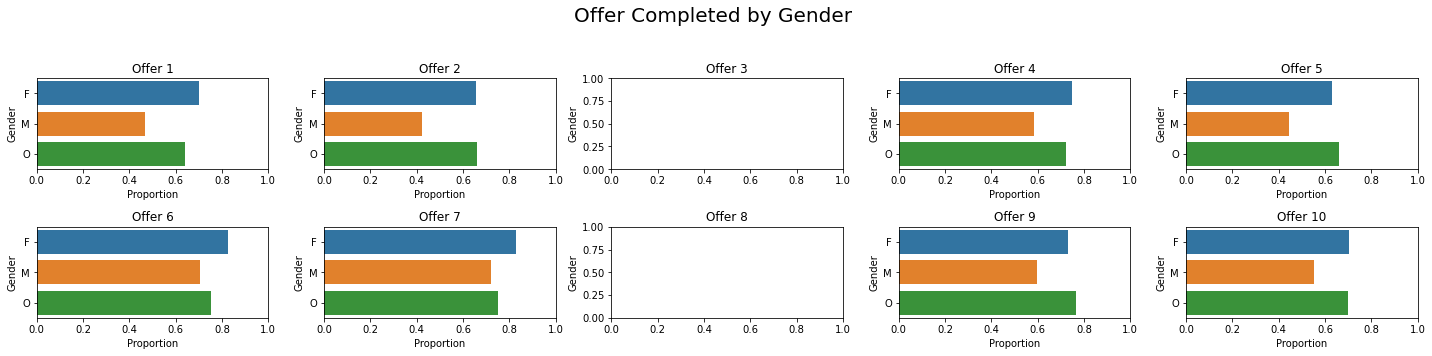

In [99]:
# Offer complete by gender.
fig, ax = plt.subplots(2,5, figsize=(20,5))
ax = ax.flatten()

for i, offer in enumerate(completed_customers):
    # This code breaks for offers 3 and 8 because 
    # the query statement pipes an empty df into sns.barplot.
    # Code cells further below don't have this problem,
    # so consider converting the code at some point.
    if (i != 3-1) and (i != 8-1): 
        (offer.groupby('gender')['offer_completed']
              .value_counts(normalize=True)
              .rename('Proportion')
              .reset_index()
              .query("offer_completed == 1")
              .pipe((sns.barplot, 'data'),
                    ax=ax[i],
                    y='gender',
                    x='Proportion',
                    ci=None)
        )

    ax[i].set_title(f"Offer {i+1}")
    ax[i].set_xlim((0,1))
    ax[i].set_ylabel("Gender")

fig.suptitle('Offer Completed by Gender \n', size=20)
plt.tight_layout();

<br><br>

The following two plots show view and completion rates across the age of the customers. Note that the 100-105 age category has a small number of customers.

Rates differ amongst different ages on a per offer basis. However, there do not appear to be strong trends.

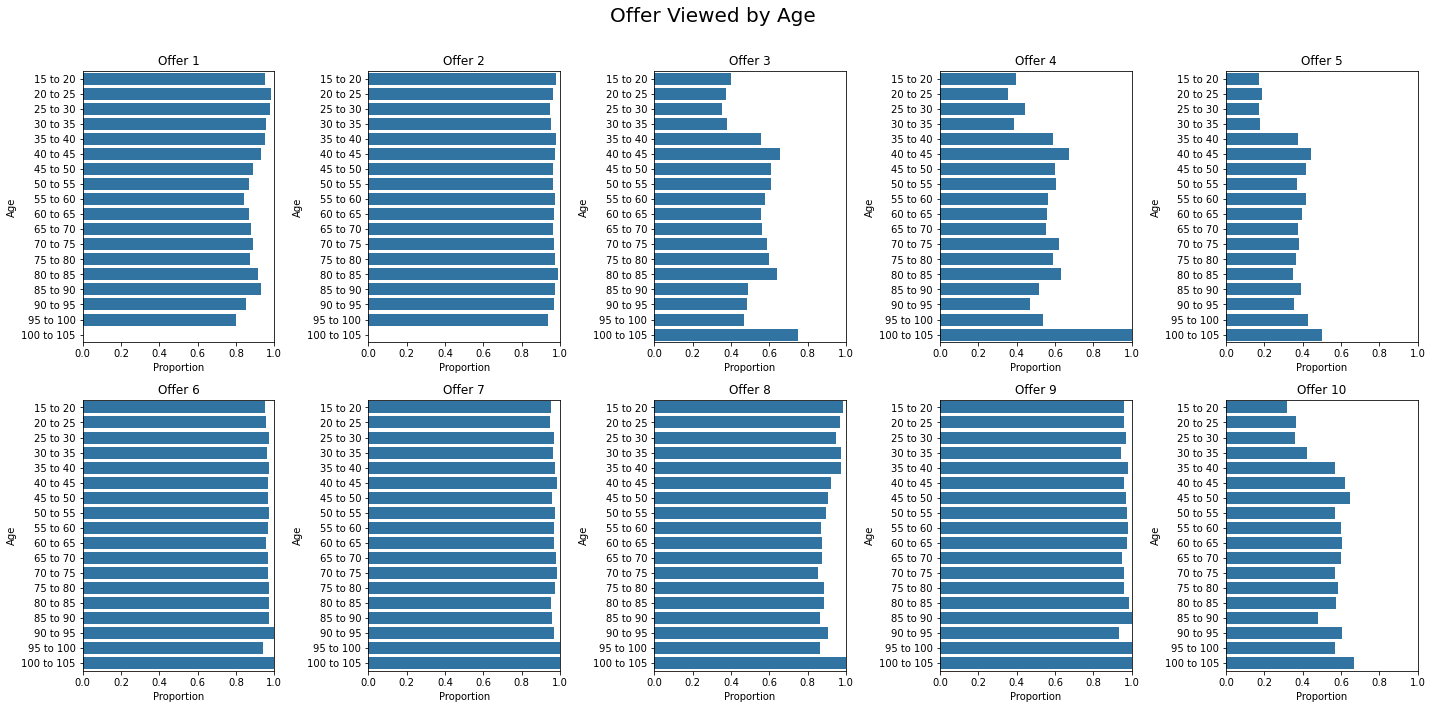

In [82]:
# offer viewed by age
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()

for i, offer in enumerate(viewed_customers):
    # Compute proportions
    undone = offer[offer.offer_viewed == 0]
    done = offer[offer.offer_viewed == 1]
    bins = np.arange(15,110,5)
    undone = pd.cut(undone['age'], bins=bins).value_counts().sort_index()
    done = pd.cut(done['age'], bins=bins).value_counts().sort_index()
    data = (done/(undone + done))
    # Reformat the index label
    data.index = data.index.map(lambda x: f"{x.left} to {x.right}")
    # Relabel
    data = data.reset_index()
    data = data.rename(columns={'age': 'Proportion', 'index': 'Age'})
    # Plot
    sns.barplot(ax=ax[i], data=data, x='Proportion', y='Age', color='tab:blue')
    ax[i].set_title(f"Offer {i+1}")
    ax[i].set_xlim(0,1)
    
fig.suptitle('Offer Viewed by Age \n', size=20);
plt.tight_layout()

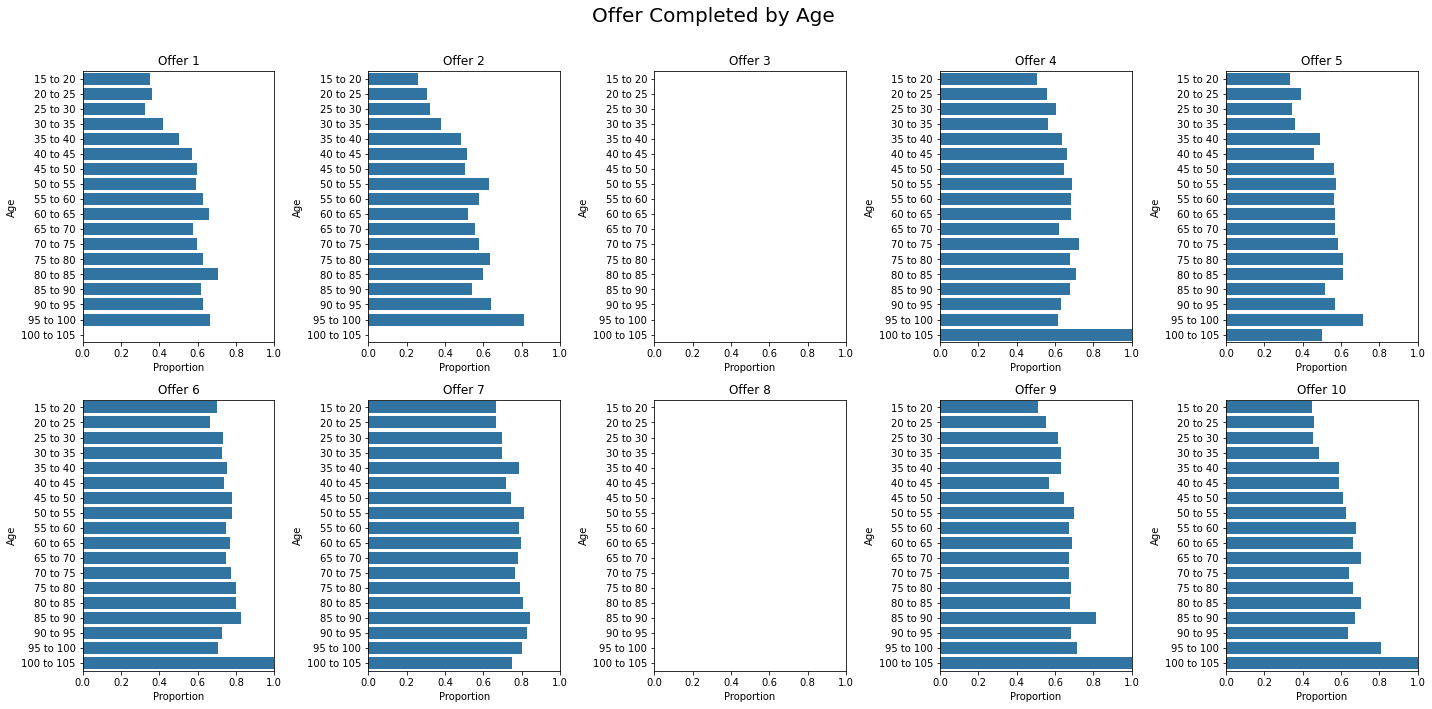

In [83]:
# offer completed by age
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()

for i, offer in enumerate(completed_customers):
    # Compute proportions
    undone = offer[offer.offer_completed == 0]
    done = offer[offer.offer_completed == 1]
    bins = np.arange(15,110,5)
    undone = pd.cut(undone['age'], bins=bins).value_counts().sort_index()
    done = pd.cut(done['age'], bins=bins).value_counts().sort_index()
    data = (done/(undone + done))
    # Reformat the index label
    data.index = data.index.map(lambda x: f"{x.left} to {x.right}")
    # Relabel
    data = data.reset_index()
    data = data.rename(columns={'age': 'Proportion', 'index': 'Age'})
    # Plot
    sns.barplot(ax=ax[i], data=data, x='Proportion', y='Age', color='tab:blue')
    ax[i].set_title(f"Offer {i+1}")
    ax[i].set_xlim(0,1)
    
fig.suptitle('Offer Completed by Age \n', size=20);
plt.tight_layout()

<br><br>

The following two plots show view/completion rates across incomes. Interestingly, there is a trend of higher offer completion amongst customers with higher incomes.

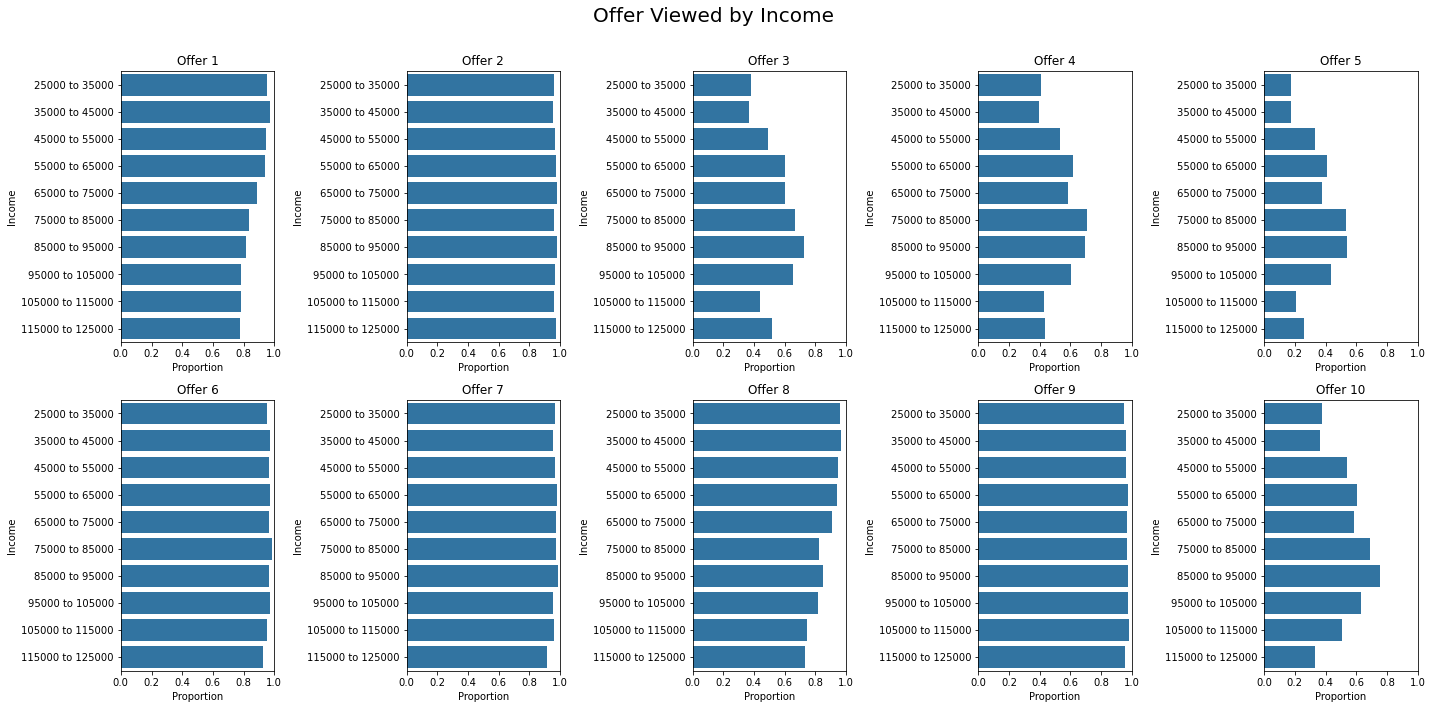

In [84]:
# offer viewed by income
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()

for i, offer in enumerate(viewed_customers):
    # Compute proportions
    undone = offer[offer.offer_viewed == 0]
    done = offer[offer.offer_viewed == 1]
    bins = np.arange(25000,135000,10000)
    undone = pd.cut(undone['income'], bins=bins).value_counts().sort_index()
    done = pd.cut(done['income'], bins=bins).value_counts().sort_index()
    data = (done/(undone + done))
    # Reformat the index label
    data.index = data.index.map(lambda x: f"{x.left} to {x.right}")
    # Relabel
    data = data.reset_index()
    data = data.rename(columns={'income': 'Proportion', 'index': 'Income'})
    # Plot
    sns.barplot(ax=ax[i], data=data, x='Proportion', y='Income', color='tab:blue')
    ax[i].set_title(f"Offer {i+1}")
    ax[i].set_xlim(0,1)
    
fig.suptitle('Offer Viewed by Income \n', size=20);
plt.tight_layout()

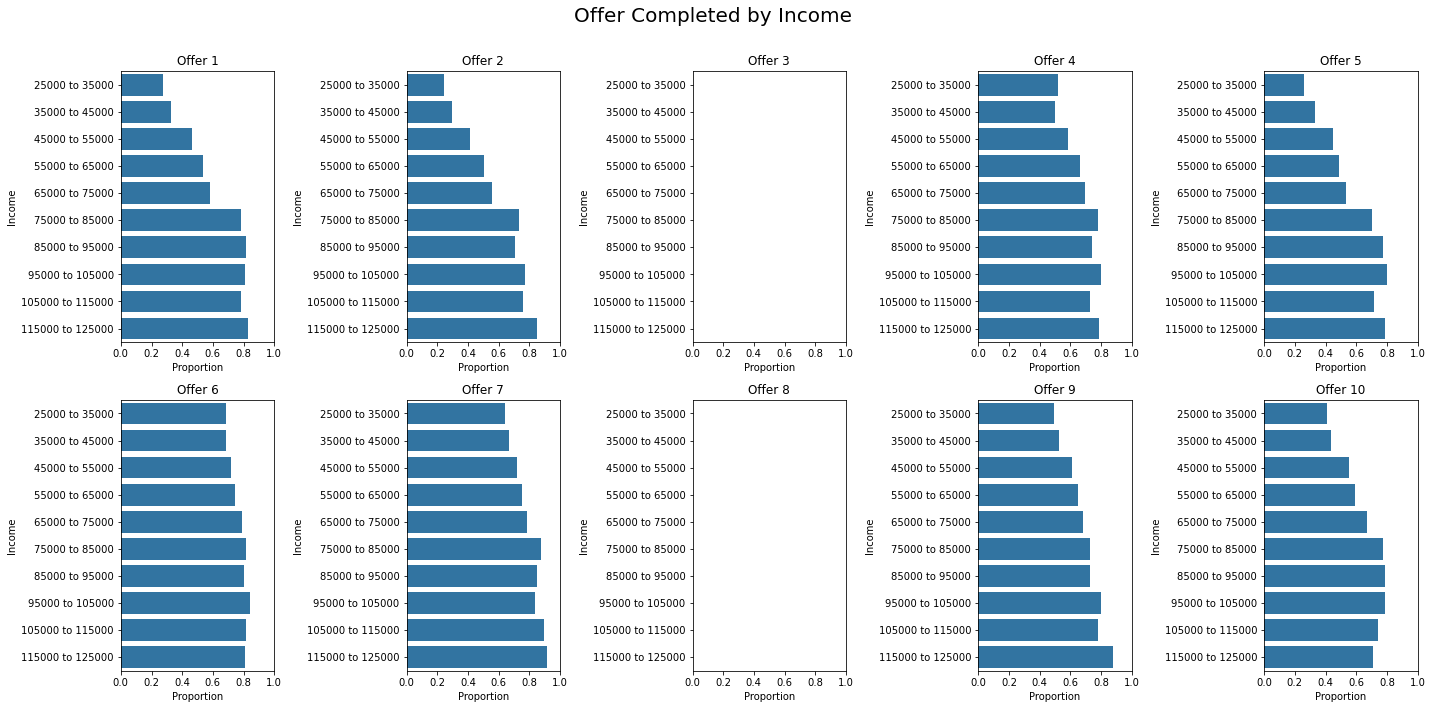

In [85]:
# offer completed by income
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()

for i, offer in enumerate(completed_customers):
    # Compute proportions
    undone = offer[offer.offer_completed == 0]
    done = offer[offer.offer_completed == 1]
    bins = np.arange(25000,135000,10000)
    undone = pd.cut(undone['income'], bins=bins).value_counts().sort_index()
    done = pd.cut(done['income'], bins=bins).value_counts().sort_index()
    data = (done/(undone + done))
    # Reformat the index label
    data.index = data.index.map(lambda x: f"{x.left} to {x.right}")
    # Relabel
    data = data.reset_index()
    data = data.rename(columns={'income': 'Proportion', 'index': 'Income'})
    # Plot
    sns.barplot(ax=ax[i], data=data, x='Proportion', y='Income', color='tab:blue')
    ax[i].set_title(f"Offer {i+1}")
    ax[i].set_xlim(0,1)
    
fig.suptitle('Offer Completed by Income \n', size=20);
plt.tight_layout()

<br><br>

The following two plots show view/completion rates by year in which a customer signed up. There do not appear to be strong general trends.

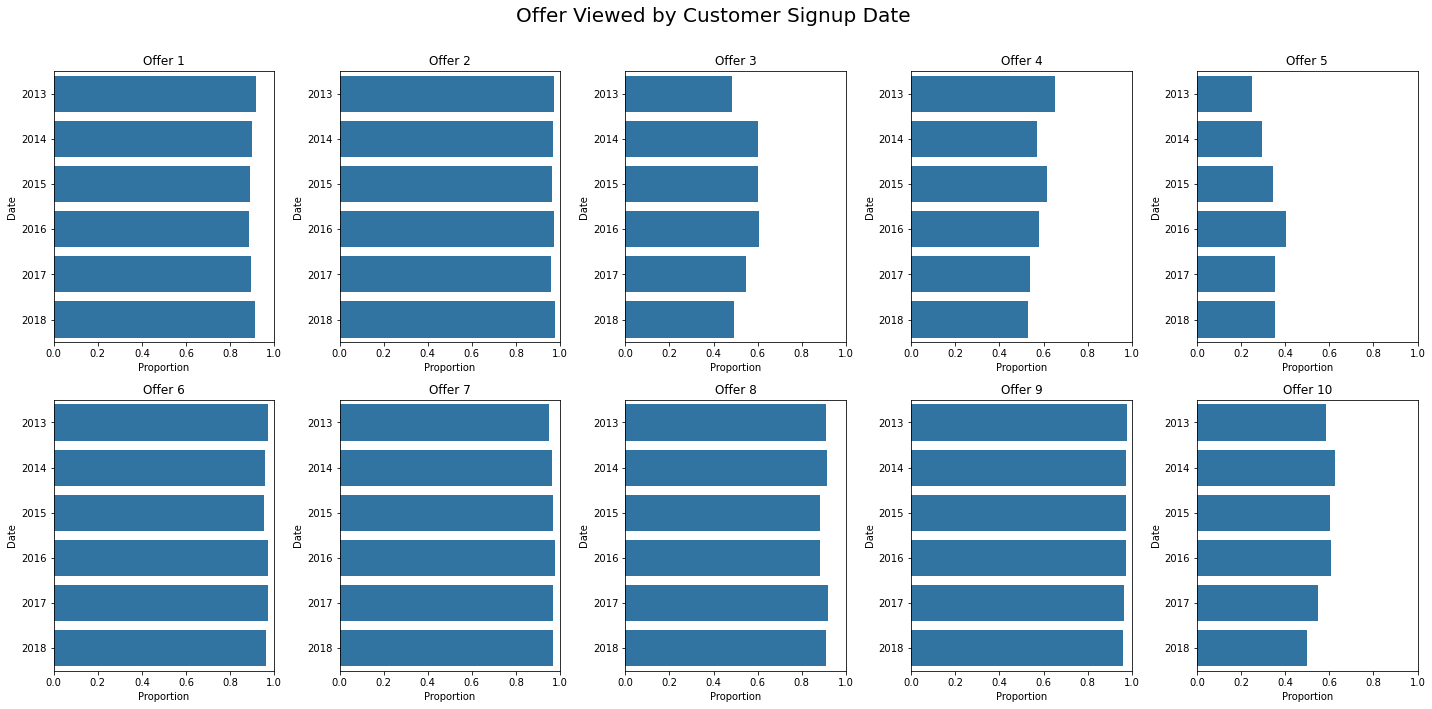

In [87]:
# offer viewed by date (resampled into year bins)
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()

for i, offer in enumerate(viewed_customers):
    # Compute proportions
    undone = offer[offer.offer_viewed == 0]
    done = offer[offer.offer_viewed == 1]
    undone = undone.became_member_on.value_counts().resample('Y').sum().rename('undone')
    done = done.became_member_on.value_counts().resample('Y').sum().rename('done')
    data = pd.concat([undone, done], axis=1, join='outer').fillna(0)
    data['proportion'] = data.done/(data.undone + data.done)
    data = data.reset_index().rename(columns={'index': 'date'})
    # Turn dates into just the year string
    data['date'] = data['date'].dt.strftime('%Y')
    # Plot
    sns.barplot(ax=ax[i], data=data, x='proportion', y='date', color='tab:blue')
    ax[i].set_title(f"Offer {i+1}")
    ax[i].set_xlabel("Proportion")
    ax[i].set_ylabel("Date")
    ax[i].set_xlim(0,1)
    
fig.suptitle('Offer Viewed by Customer Signup Date \n', size=20);
plt.tight_layout()

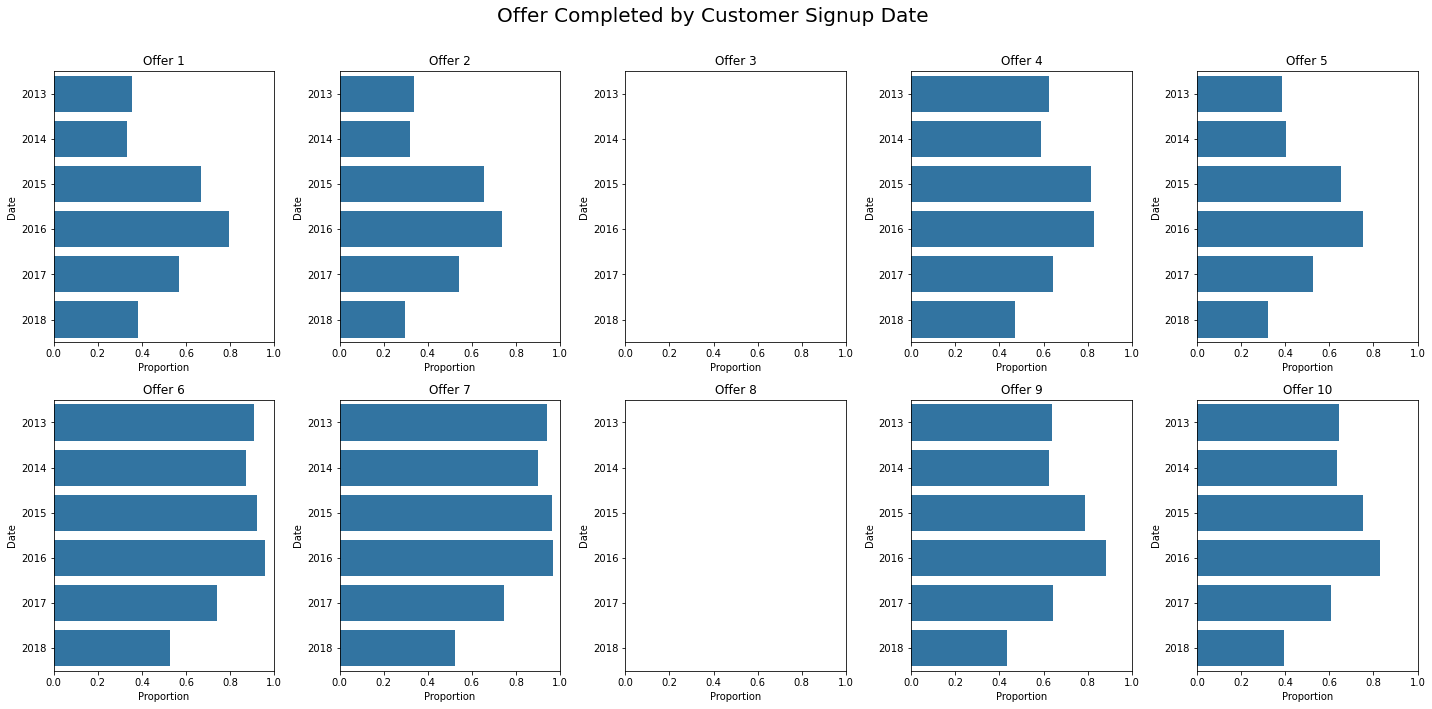

In [88]:
# offer completed by date (resampled into year bins)
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()

for i, offer in enumerate(completed_customers):
    # Compute proportions
    undone = offer[offer.offer_completed == 0]
    done = offer[offer.offer_completed == 1]
    undone = undone.became_member_on.value_counts().resample('Y').sum().rename('undone')
    done = done.became_member_on.value_counts().resample('Y').sum().rename('done')
    data = pd.concat([undone, done], axis=1, join='outer').fillna(0)
    data['proportion'] = data.done/(data.undone + data.done)
    data = data.reset_index().rename(columns={'index': 'date'})
    # Turn dates into just the year string
    data['date'] = data['date'].dt.strftime('%Y')
    # Plot
    sns.barplot(ax=ax[i], data=data, x='proportion', y='date', color='tab:blue')
    ax[i].set_title(f"Offer {i+1}")
    ax[i].set_xlabel("Proportion")
    ax[i].set_ylabel("Date")
    ax[i].set_xlim(0,1)
    
fig.suptitle('Offer Completed by Customer Signup Date \n', size=20);
plt.tight_layout()

## Conclusions and Discussion

Compare between groups?

<br><br>

# References

https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group